# Face Recognition with Unknown Detection

This notebook demonstrates face recognition with unknown person detection using FaceNet embeddings and SVM classification.

## 1. Install Dependencies

In [75]:
!pip install mtcnn keras-facenet opencv-python scikit-learn numpy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import Libraries

In [76]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

## 3. Initialize Constants and Models

In [87]:
# Constants
DATA_DIR = "C:\\VS Code\\My AI ML Models\\Face Recognisition\\dataset"  # Replace with your dataset path
TARGET_SIZE = (160, 160)
UNKNOWN_THRESHOLD_PERCENTILE = 5  # 5th percentile probability threshold

# Initialize FaceNet and MTCNN
embedder = FaceNet()
detector = MTCNN()

## 4. Data Loading and Preprocessing

In [78]:
class FaceLoader:
    def __init__(self, directory):
        self.directory = directory
        self.X = []  # Faces
        self.Y = []  # Labels

    def extract_face(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(img)
        if not results:
            return None
        x, y, w, h = results[0]['box']
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, TARGET_SIZE)
        return face

    def load_faces(self, dir):
        faces = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                face = self.extract_face(path)
                if face is not None:
                    faces.append(face)
            except Exception as e:
                print(f"Skipped {im_name}: {str(e)}")
        return faces

    def load_classes(self):
        for person_name in os.listdir(self.directory):
            person_dir = os.path.join(self.directory, person_name)
            if not os.path.isdir(person_dir):
                continue
            faces = self.load_faces(person_dir)
            labels = [person_name for _ in range(len(faces))]
            self.X.extend(faces)
            self.Y.extend(labels)
            print(f"Loaded {len(labels)} samples for {person_name}")
        return np.array(self.X), np.array(self.Y)

## 5. Face Embedding Extraction

In [79]:
def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    return embedder.embeddings(face_img)[0]

## 6. Model Training

In [ ]:
def train_model(X, Y):
    # Encode labels
    encoder = LabelEncoder()
    Y_encoded = encoder.fit_transform(Y)
    
    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y_encoded, test_size=0.2, random_state=42
    )
    
    # Train SVM
    model = SVC(kernel='linear', probability=True)
    model.fit(X_train, Y_train)
    
    # Calculate threshold
    prob_train = model.predict_proba(X_train)
    max_probs_train = np.max(prob_train, axis=1)
    threshold = np.percentile(max_probs_train, UNKNOWN_THRESHOLD_PERCENTILE)
    
    # Evaluate
    train_acc = accuracy_score(Y_train, model.predict(X_train))
    test_acc = accuracy_score(Y_test, model.predict(X_test))
    print(f"Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")
    print(f"Threshold (Reject if prob < {threshold:.3f})")
    
    return model, encoder, threshold

## 7. Model Saving/Loading

In [81]:
def save_model(model, encoder, threshold, filename='face_recognition_model.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump({
            'model': model,
            'encoder': encoder,
            'threshold': threshold
        }, f)

def load_model(filename='face_recognition_model.pkl'):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data['model'], data['encoder'], data['threshold']

## 8. Prediction Function

In [82]:
def predict_face(model, encoder, threshold, face_img):
    # Get embedding
    embedding = get_embedding(face_img)
    
    # Predict probabilities
    prob = model.predict_proba([embedding])[0]
    max_prob = np.max(prob)
    
    # Check threshold
    if max_prob < threshold:
        return "unknown"
    else:
        pred_class = model.predict([embedding])[0]
        return encoder.inverse_transform([pred_class])[0]

## 9. Main Workflow Execution

### Step 1: Load and Preprocess Data

In [83]:
# Initialize data loader
loader = FaceLoader(DATA_DIR)
X, Y = loader.load_classes()

Loaded 3 samples for anand
Loaded 10 samples for jenna_ortega
Loaded 9 samples for robert_downey
Loaded 10 samples for sardor_abdirayimov
Loaded 3 samples for shubham
Loaded 10 samples for taylor_swift


### Step 2: Extract Face Embeddings

In [84]:
print("Extracting face embeddings...")
X_embeddings = np.array([get_embedding(face) for face in X])

Extracting face embeddings...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/ste

### Step 3: Train and Save Model

In [85]:
model, encoder, threshold = train_model(X_embeddings, Y)
save_model(model, encoder, threshold)

Train Accuracy: 1.00, Test Accuracy: 1.00
Threshold (Reject if prob < 0.658)


### Step 4: Test on New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted Identity: taylor_swift


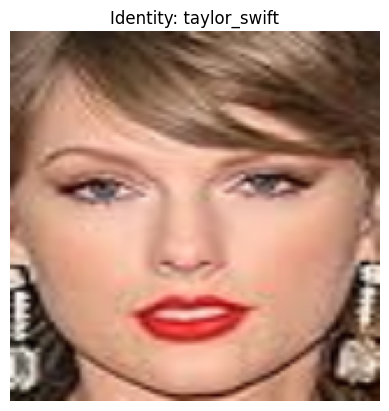

In [94]:
# Load test image
test_img_path = "C:\\VS Code\\My AI ML Models\\Face Recognisition\\test_images\\taylor_swift_test.jpg"  # Replace with your test image
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Detect face
results = detector.detect_faces(test_img)
if not results:
    print("No face detected!")
else:
    x, y, w, h = results[0]['box']
    face = test_img[y:y+h, x:x+w]
    face = cv2.resize(face, TARGET_SIZE)
    
    # Predict
    identity = predict_face(model, encoder, threshold, face)
    print(f"Predicted Identity: {identity}")
    
    # Display
    plt.imshow(face)
    plt.title(f"Identity: {identity}")
    plt.axis('off')
    plt.show()